# Artificial Neural Network with TensorFlow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Data Loading

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28 * 28) / 255
X_test = X_test.astype(np.float32).reshape(-1, 28 * 28) / 255
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[: 5000], X_train[5000:]
y_valid, y_train = y_train[: 5000], y_train[5000:]

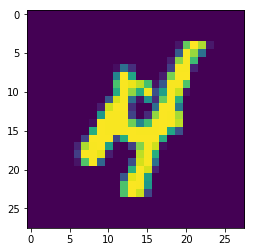

In [3]:
plt.imshow(X_train[777].reshape(28, 28));

## Plain TensorFlow
### Defining Parameters

In [5]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
learning_rate = 0.01

### Defining Placeholders

In [8]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')

### Defining Layers

In [9]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name='kernel')
        b = tf.Variable(tf.zeros([n_neurons]), name='bias')
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [10]:
with tf.name_scope('dnn'):
    hidden1 = neuron_layer(X, n_hidden1, name='hidden1', activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name='hidden2', activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name='outputs')

### Defining Loss Function

In [11]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

### Training Model

In [12]:
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

### Evaluating Model

In [13]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

### Running Model

In [14]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [15]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [16]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Batch accuracy:', acc_batch, 'Val accuracy:', acc_val)

    save_path = saver.save(sess, './Models/tf_plain_example.ckpt')

0 Batch accuracy: 0.96 Val accuracy: 0.9152
1 Batch accuracy: 0.98 Val accuracy: 0.934
2 Batch accuracy: 0.92 Val accuracy: 0.9426
3 Batch accuracy: 0.96 Val accuracy: 0.9514
4 Batch accuracy: 0.94 Val accuracy: 0.9562
5 Batch accuracy: 0.98 Val accuracy: 0.959
6 Batch accuracy: 0.96 Val accuracy: 0.962
7 Batch accuracy: 0.96 Val accuracy: 0.9646
8 Batch accuracy: 0.94 Val accuracy: 0.9674
9 Batch accuracy: 1.0 Val accuracy: 0.9676
10 Batch accuracy: 0.92 Val accuracy: 0.9698
11 Batch accuracy: 1.0 Val accuracy: 0.9702
12 Batch accuracy: 0.98 Val accuracy: 0.9704
13 Batch accuracy: 0.98 Val accuracy: 0.972
14 Batch accuracy: 0.96 Val accuracy: 0.972
15 Batch accuracy: 0.98 Val accuracy: 0.9728
16 Batch accuracy: 0.98 Val accuracy: 0.9742
17 Batch accuracy: 1.0 Val accuracy: 0.9748
18 Batch accuracy: 1.0 Val accuracy: 0.9742
19 Batch accuracy: 0.98 Val accuracy: 0.9748
20 Batch accuracy: 0.98 Val accuracy: 0.9756
21 Batch accuracy: 0.98 Val accuracy: 0.9756
22 Batch accuracy: 0.98 Val a

### Predicting Data

In [17]:
with tf.Session() as sess:
    saver.restore(sess, save_path)
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./tf_plain_example.ckpt


In [18]:
print('Predicted classes:', y_pred)
print('Actual classes:   ', y_test[:20])

Predicted classes: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


## Layers API
### Defining Parameters

In [20]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
learning_rate = 0.01

### Defining Placeholders

In [21]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')

### Defining Layers

In [22]:
with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1', activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name='hidden2', activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name='outputs')
    y_proba = tf.nn.softmax(logits)

### Defining Loss Function

In [23]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

### Training Model

In [24]:
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

### Evaluating Model

In [25]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

### Running Model

In [26]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [27]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [28]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Batch accuracy:', acc_batch, 'Val accuracy:', acc_val)

    save_path = saver.save(sess, './Models/tf_example.ckpt')

0 Batch accuracy: 0.92 Val accuracy: 0.9056
1 Batch accuracy: 0.94 Val accuracy: 0.9216
2 Batch accuracy: 0.92 Val accuracy: 0.9334
3 Batch accuracy: 0.98 Val accuracy: 0.939
4 Batch accuracy: 0.98 Val accuracy: 0.9442
5 Batch accuracy: 0.94 Val accuracy: 0.9524
6 Batch accuracy: 0.96 Val accuracy: 0.9526
7 Batch accuracy: 0.98 Val accuracy: 0.9574
8 Batch accuracy: 0.92 Val accuracy: 0.96
9 Batch accuracy: 1.0 Val accuracy: 0.9618
10 Batch accuracy: 0.94 Val accuracy: 0.9654
11 Batch accuracy: 0.98 Val accuracy: 0.9636
12 Batch accuracy: 0.98 Val accuracy: 0.9664
13 Batch accuracy: 0.96 Val accuracy: 0.9672
14 Batch accuracy: 0.96 Val accuracy: 0.9684
15 Batch accuracy: 1.0 Val accuracy: 0.9688
16 Batch accuracy: 0.96 Val accuracy: 0.9714
17 Batch accuracy: 1.0 Val accuracy: 0.971
18 Batch accuracy: 1.0 Val accuracy: 0.9722
19 Batch accuracy: 1.0 Val accuracy: 0.9732
20 Batch accuracy: 1.0 Val accuracy: 0.9736
21 Batch accuracy: 0.98 Val accuracy: 0.9748
22 Batch accuracy: 1.0 Val acc

### Predicting Data

In [29]:
with tf.Session() as sess:
    saver.restore(sess, save_path)
    X_new_scaled = X_test[: 20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./tf_example.ckpt


In [30]:
print('Predicted classes:', y_pred)
print('Actual classes:   ', y_test[: 20])

Predicted classes: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


## Estimator API
### Defining Features

In [31]:
feature_cols = [tf.feature_column.numeric_column('X', shape=[28 * 28])]

### Initializing Estimator

In [32]:
dnn_clf = tf.estimator.DNNClassifier(hidden_units=[300, 100], n_classes=10,
                                     feature_columns=feature_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpq3b__z60', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbb18b078d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Defining Inputs

In [33]:
input_fn = tf.estimator.inputs.numpy_input_fn(x={'X': X_train}, y=y_train, 
                                              num_epochs=40, batch_size=50, shuffle=True)

test_input_fn = tf.estimator.inputs.numpy_input_fn(x={'X': X_test}, y=y_test, shuffle=False)

### Training Model

In [34]:
dnn_clf.train(input_fn=input_fn)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpq3b__z60/model.ckpt.
INFO:tensorflow:loss = 115.4211, step = 1
INFO:tensorflow:global_step/sec: 143.156
INFO:tensorflow:loss = 12.002026, step = 101 (0.701 sec)
INFO:tensorflow:global_step/sec: 216.059
INFO:tensorflow:loss = 14.102783, step = 201 (0.461 sec)
INFO:tensorflow:global_step/sec: 242.853
INFO:tensorflow:loss = 10.968423, step = 301 (0.412 sec)
INFO:tensorflow:global_step/sec: 241.627
INFO:tensorflow:loss = 15.912615, step = 401 (0.413 sec)
INFO:

INFO:tensorflow:global_step/sec: 186.504
INFO:tensorflow:loss = 0.43571228, step = 7001 (0.535 sec)
INFO:tensorflow:global_step/sec: 170.951
INFO:tensorflow:loss = 0.4166721, step = 7101 (0.585 sec)
INFO:tensorflow:global_step/sec: 176.209
INFO:tensorflow:loss = 0.50303465, step = 7201 (0.568 sec)
INFO:tensorflow:global_step/sec: 183.253
INFO:tensorflow:loss = 0.9976653, step = 7301 (0.546 sec)
INFO:tensorflow:global_step/sec: 171.22
INFO:tensorflow:loss = 0.8607987, step = 7401 (0.583 sec)
INFO:tensorflow:global_step/sec: 200.456
INFO:tensorflow:loss = 0.3885249, step = 7501 (0.498 sec)
INFO:tensorflow:global_step/sec: 193.087
INFO:tensorflow:loss = 3.3511584, step = 7601 (0.519 sec)
INFO:tensorflow:global_step/sec: 185.321
INFO:tensorflow:loss = 0.4166223, step = 7701 (0.538 sec)
INFO:tensorflow:global_step/sec: 182.917
INFO:tensorflow:loss = 0.3103042, step = 7801 (0.547 sec)
INFO:tensorflow:global_step/sec: 177.353
INFO:tensorflow:loss = 0.3875909, step = 7901 (0.564 sec)
INFO:tens

INFO:tensorflow:global_step/sec: 226.713
INFO:tensorflow:loss = 0.23051222, step = 15201 (0.441 sec)
INFO:tensorflow:global_step/sec: 226.949
INFO:tensorflow:loss = 0.3595723, step = 15301 (0.442 sec)
INFO:tensorflow:global_step/sec: 214.357
INFO:tensorflow:loss = 0.09301325, step = 15401 (0.468 sec)
INFO:tensorflow:global_step/sec: 188.452
INFO:tensorflow:loss = 0.060594857, step = 15501 (0.529 sec)
INFO:tensorflow:global_step/sec: 177.692
INFO:tensorflow:loss = 0.013245817, step = 15601 (0.561 sec)
INFO:tensorflow:global_step/sec: 162.632
INFO:tensorflow:loss = 0.03258927, step = 15701 (0.615 sec)
INFO:tensorflow:global_step/sec: 176.964
INFO:tensorflow:loss = 0.020537276, step = 15801 (0.567 sec)
INFO:tensorflow:global_step/sec: 156.395
INFO:tensorflow:loss = 0.20265563, step = 15901 (0.640 sec)
INFO:tensorflow:global_step/sec: 171.635
INFO:tensorflow:loss = 0.24905472, step = 16001 (0.582 sec)
INFO:tensorflow:global_step/sec: 170.652
INFO:tensorflow:loss = 0.08544068, step = 16101 

INFO:tensorflow:global_step/sec: 169.08
INFO:tensorflow:loss = 0.087503046, step = 23301 (0.592 sec)
INFO:tensorflow:global_step/sec: 170.509
INFO:tensorflow:loss = 0.061020818, step = 23401 (0.589 sec)
INFO:tensorflow:global_step/sec: 178.933
INFO:tensorflow:loss = 0.006470556, step = 23501 (0.558 sec)
INFO:tensorflow:global_step/sec: 128.885
INFO:tensorflow:loss = 0.041038875, step = 23601 (0.779 sec)
INFO:tensorflow:global_step/sec: 125.452
INFO:tensorflow:loss = 0.008085244, step = 23701 (0.792 sec)
INFO:tensorflow:global_step/sec: 166.036
INFO:tensorflow:loss = 0.062359653, step = 23801 (0.605 sec)
INFO:tensorflow:global_step/sec: 176.633
INFO:tensorflow:loss = 0.006797383, step = 23901 (0.563 sec)
INFO:tensorflow:global_step/sec: 159.318
INFO:tensorflow:loss = 0.046562985, step = 24001 (0.628 sec)
INFO:tensorflow:global_step/sec: 165.557
INFO:tensorflow:loss = 0.04600975, step = 24101 (0.605 sec)
INFO:tensorflow:global_step/sec: 183.014
INFO:tensorflow:loss = 0.061722025, step = 

INFO:tensorflow:global_step/sec: 159.85
INFO:tensorflow:loss = 0.03259742, step = 31401 (0.625 sec)
INFO:tensorflow:global_step/sec: 189.367
INFO:tensorflow:loss = 0.045308713, step = 31501 (0.529 sec)
INFO:tensorflow:global_step/sec: 249.849
INFO:tensorflow:loss = 0.0023783764, step = 31601 (0.399 sec)
INFO:tensorflow:global_step/sec: 184.674
INFO:tensorflow:loss = 0.010482566, step = 31701 (0.541 sec)
INFO:tensorflow:global_step/sec: 243.935
INFO:tensorflow:loss = 0.017387845, step = 31801 (0.410 sec)
INFO:tensorflow:global_step/sec: 196.743
INFO:tensorflow:loss = 0.038220253, step = 31901 (0.509 sec)
INFO:tensorflow:global_step/sec: 197.755
INFO:tensorflow:loss = 0.089130655, step = 32001 (0.505 sec)
INFO:tensorflow:global_step/sec: 258.766
INFO:tensorflow:loss = 0.011082405, step = 32101 (0.386 sec)
INFO:tensorflow:global_step/sec: 233.212
INFO:tensorflow:loss = 0.01786149, step = 32201 (0.429 sec)
INFO:tensorflow:global_step/sec: 185.567
INFO:tensorflow:loss = 0.012793759, step = 

INFO:tensorflow:loss = 0.011795448, step = 39401 (0.462 sec)
INFO:tensorflow:global_step/sec: 229.826
INFO:tensorflow:loss = 0.01894587, step = 39501 (0.437 sec)
INFO:tensorflow:global_step/sec: 247.904
INFO:tensorflow:loss = 0.03097219, step = 39601 (0.402 sec)
INFO:tensorflow:global_step/sec: 248.822
INFO:tensorflow:loss = 0.0036655797, step = 39701 (0.410 sec)
INFO:tensorflow:global_step/sec: 238.84
INFO:tensorflow:loss = 0.0021938672, step = 39801 (0.412 sec)
INFO:tensorflow:global_step/sec: 248.426
INFO:tensorflow:loss = 0.042205278, step = 39901 (0.402 sec)
INFO:tensorflow:global_step/sec: 235.705
INFO:tensorflow:loss = 0.013201911, step = 40001 (0.424 sec)
INFO:tensorflow:global_step/sec: 194.93
INFO:tensorflow:loss = 0.033668038, step = 40101 (0.514 sec)
INFO:tensorflow:global_step/sec: 201.529
INFO:tensorflow:loss = 0.0065653916, step = 40201 (0.494 sec)
INFO:tensorflow:global_step/sec: 208.173
INFO:tensorflow:loss = 0.016862744, step = 40301 (0.481 sec)
INFO:tensorflow:global

### Evaluating Model

In [35]:
eval_results = dnn_clf.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-27-14:56:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpq3b__z60/model.ckpt-44000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-01-27-14:56:46
INFO:tensorflow:Saving dict for global step 44000: accuracy = 0.9787, average_loss = 0.09775799, global_step = 44000, loss = 12.374429
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 44000: /tmp/tmpq3b__z60/model.ckpt-44000


In [36]:
eval_results

{'accuracy': 0.9787,
 'average_loss': 0.09775799,
 'loss': 12.374429,
 'global_step': 44000}

### Predicting Data

In [37]:
y_pred_iter = dnn_clf.predict(input_fn=test_input_fn)
y_pred = list(y_pred_iter)
y_pred[0]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpq3b__z60/model.ckpt-44000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'logits': array([ -3.167969  ,  -3.8131082 ,  -8.650086  ,   4.233424  ,
        -13.740841  ,  -0.23243701, -12.481055  ,  15.392525  ,
         -7.4812083 ,  -0.77521473], dtype=float32),
 'probabilities': array([8.6950847e-09, 4.5613477e-09, 3.6176017e-11, 1.4244851e-05,
        2.2260441e-13, 1.6374157e-07, 7.8460545e-13, 9.9998546e-01,
        1.1642801e-10, 9.5155407e-08], dtype=float32),
 'class_ids': array([7]),
 'classes': array([b'7'], dtype=object)}

## Keras

In [52]:
from keras.models import Sequential, load_model

dnn_keras_model = Sequential()

### Defining Layers

In [59]:
from keras.layers import Dense

dnn_keras_model.add(Dense(units=300, input_dim=784, activation='relu'))
dnn_keras_model.add(Dense(units=100, activation='relu'))
dnn_keras_model.add(Dense(units=10, activation='softmax'))

### Compiling Model

In [60]:
dnn_keras_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Defining Early Stopping

In [61]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=2)

### Training Model

In [64]:
dnn_keras_model.fit(X_train, y_train, epochs=40, validation_split=0.3, callbacks=[early_stopping_monitor])

Train on 38500 samples, validate on 16500 samples
Epoch 1/40
38500/38500 [==============================] - 13s 350us/step - loss: 0.4506 - acc: 0.8546 - val_loss: 0.1756 - val_acc: 0.9515
Epoch 2/40
38500/38500 [==============================] - 12s 304us/step - loss: 0.1401 - acc: 0.9602 - val_loss: 0.1513 - val_acc: 0.9587
Epoch 3/40
38500/38500 [==============================] - 12s 320us/step - loss: 0.0929 - acc: 0.9727 - val_loss: 0.1288 - val_acc: 0.9659
Epoch 4/40
38500/38500 [==============================] - 15s 391us/step - loss: 0.0731 - acc: 0.9789 - val_loss: 0.1249 - val_acc: 0.9671
Epoch 5/40
38500/38500 [==============================] - 12s 307us/step - loss: 0.0583 - acc: 0.9830 - val_loss: 0.1246 - val_acc: 0.9681
Epoch 6/40
38500/38500 [==============================] - 8s 219us/step - loss: 0.0505 - acc: 0.9858 - val_loss: 0.1251 - val_acc: 0.9675
Epoch 7/40
38500/38500 [==============================] - 8s 220us/step - loss: 0.0433 - acc: 0.9877 - val_loss: 0.11

In [65]:
dnn_keras_model.save('./Models/keras_example.h5')

### Predicting Data

In [68]:
dnn_keras_model = load_model('./Models/keras_example.h5')

In [78]:
predictions = dnn_keras_model.predict_classes(X_test)

### Evaluating Model

In [79]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(predictions, y_test))
print(confusion_matrix(predictions, y_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       998
           1       1.00      0.98      0.99      1159
           2       0.98      0.98      0.98      1027
           3       0.98      0.95      0.97      1038
           4       0.96      0.98      0.97       962
           5       0.95      0.98      0.97       867
           6       0.97      0.98      0.98       949
           7       0.98      0.98      0.98      1034
           8       0.97      0.97      0.97       969
           9       0.97      0.98      0.97       997

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.97      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

[[ 971    0    3    0    4    2   10    2    1    5]
 [   1 1131    4    2    3    1    3    6    4    4]
 [   1    1 1008    5    4    0    0    4    4    0]
 [   1    0    4  991    0   27    1    3    6    5]
 [   0    0    2    0  947   